In [296]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from statsmodels.stats.weightstats import CompareMeans

#from dateutil import relativedelta
#import datetime

### Import the data

In [297]:
data = pd.read_csv('A2_csv.csv', encoding='cp1252', sep=';', na_filter=False, low_memory=False)

There a couple of raws with no data, thus we will delete them.

_Note: it is worth to mention that there are no duplicates_

In [298]:
data = data[data['rating']!='']

Convert variables to numeric format

In [299]:
data['intodefault'] = pd.to_numeric(data['intodefault'], errors='coerce')
data['intodefault'] = data['intodefault'].fillna(0)

data['healthy'] = pd.to_numeric(data['healthy'], errors='coerce')
data['healthy'] = data['healthy'].fillna(0)

data['rating_num'] = pd.to_numeric(data['rating'])
data['rating_num'] = data['rating_num'].map(lambda x: int(x))

Convert and standartize date formats 

In [300]:
dates = pd.to_datetime(data['reporting_date'], format = '%d%b%Y', errors='coerce')

excel_dates = pd.to_numeric(data['reporting_date'], errors='coerce')
excel_dates = pd.to_datetime('1899-12-30') + pd.to_timedelta(excel_dates,'D', errors='coerce')

dates[dates.isnull()] = excel_dates[excel_dates.isnull()==False]

data['reporting_date'] = dates

In [473]:
#data.describe()
#data.describe(include=['O'])

,customer_id,outstanding_amount,default_moment,rating,year,mrating
count,582646,582646,582646,582646,582646,582646
unique,38991,173293,37,19,4,19
top,43080811,0,,13.1,2011,13.1
freq,28,3921,554583,107573,285670,107573


***
### Testing discriminatory power

#### Function for calculation of Gini coefficient

In [278]:
def calc_gini(input_data):
    p = input_data['intodefault'].sum()/input_data['intodefault'].count()
    
    distr_data = input_data[['intodefault','rating']].groupby('rating').agg(['sum', 'count'])
    distr_data.columns = distr_data.columns.droplevel()
    distr_data.reset_index(inplace=True)
    distr_data.loc[len(distr_data)] = 0
    distr_data.sort_index(ascending=False, inplace=True)
    distr_data.reset_index(inplace=True, drop=True)

    distr_data[['sum', 'count']] = distr_data[['sum', 'count']]/distr_data[['sum', 'count']].sum()
    distr_data[['sum', 'count']] = distr_data[['sum', 'count']].cumsum()
    
    f = distr_data['sum']
    x = distr_data['count']

    i = 1
    area = 0
    while i < len(distr_data):
        area += (f[i] + f[i-1]) * (x[i] - x[i-1])
        i += 1
    gini = 100*(area-1)/(1-p)
    
    plt.figure(figsize=(6,6))
    plt.title('CAP curves')
    plt.plot([0, 1], [0, 1], color='grey')
    plt.plot(x, f)
    plt.plot([0, p, 1], [0, 1, 1])
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.legend(['random model','actual model, Gini = {:.1f}%'.format(gini),'perfect model'])
    plt.show()
    #print('Gini for actual model {:.1f}%'.format(gini))
    
    return gini

#### Cumulative accuracy profile (CAP) and Gini coefficient for the whole sample

CAP and Gini for whole sample


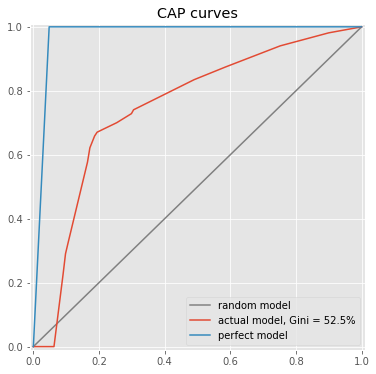

In [453]:
print ("\033[1m" + 'CAP and Gini for the whole sample'  + "\033[0;0m")
g = calc_gini(data)

#### CAP curves and Gini coefficients for different periods 

First let's check how total number of rated customers, defaults and default rates for different reporting dates

In [193]:
data[['reporting_date', 'intodefault']].groupby('reporting_date').agg(['sum', 'count', 'mean']).reset_index()

reporting_date intodefault                 
                          sum  count      mean
0      2009-08-31         1.0     33  0.030303
1      2009-09-30         1.0     38  0.026316
2      2009-10-31         0.0     66  0.000000
3      2009-11-30         0.0     71  0.000000
4      2009-12-31        19.0    481  0.039501
5      2010-01-31       801.0  17203  0.046562
6      2010-02-28       772.0  17412  0.044337
7      2010-03-31       813.0  18870  0.043084
8      2010-04-30       840.0  18712  0.044891
9      2010-05-31       892.0  18682  0.047746
10     2010-06-30      1048.0  20483  0.051164
11     2010-07-31      1040.0  22888  0.045439
12     2010-08-31      1159.0  23501  0.049317
13     2010-09-30      1278.0  23798  0.053702
14     2010-10-31      1115.0  25810  0.043200
15     2010-11-30      1118.0  25799  0.043335
16     2010-12-31      1194.0  26722  0.044682
17     2011-01-31      1221.0  27393  0.044573
18     2011-02-28      1290.0  27853  0.046315
19     2011-03-31      1336.0  28246  0.047299
20     2011-04-30      1392.0  28854  0.048243
21     2011-05-31      1507.0  29186  0.051634
22     2011-06-30      1542.0  29657  0.051994
23     2011-07-31      1386.0  29725  0.046627
24     2011-08-31      1416.0  30261  0.046793
25     2011-09-30      1508.0  30138  0.050036
26     2011-10-31      1662.0  30515  0.054465
27     2011-11-30      1712.0  30249  0.056597

We will split the sample to 5 semiannual periods (first and last 5 months) and calculate Gini for each:
- from 2009-08-31 to 2009-12-31  
- from 2010-01-31 to 2010-06-30
- from 2010-07-31 to 2010-12-31
- from 2011-01-31 to 2011-06-30
- from 2011-07-31 to 2011-11-30

CAP and Gini for window = [ 2009-08-31 , 2009-12-31 ]


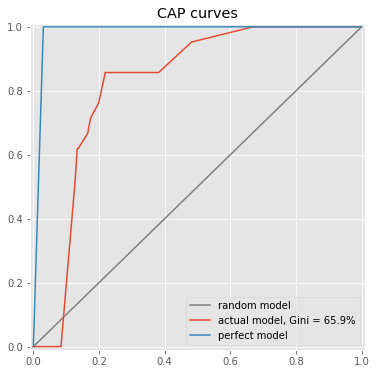

CAP and Gini for window = [ 2010-02-28 , 2010-07-31 ]


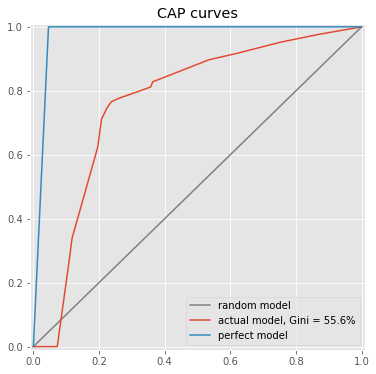

CAP and Gini for window = [ 2010-08-31 , 2011-01-31 ]


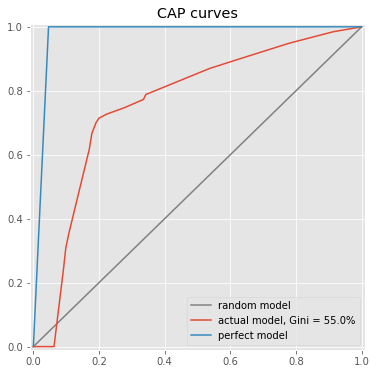

CAP and Gini for window = [ 2011-02-28 , 2011-07-31 ]


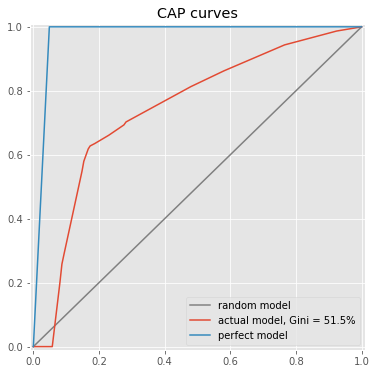

CAP and Gini for window = [ 2011-08-31 , 2011-11-30 ]


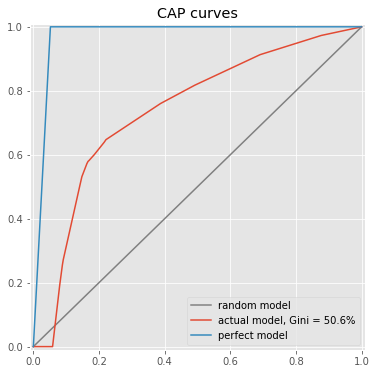

In [279]:
reporting_dates = np.sort(data['reporting_date'].unique())

window = 6
i_lower = 0
i_upper = 4
while i_lower < len(reporting_dates):
    lower = reporting_dates[i_lower]
    upper = reporting_dates[i_upper]
    mask = (data['reporting_date']>=lower) & (data['reporting_date']<=upper)
    data_short = data[mask]
    
    lower_str = pd.to_datetime(str(lower)).strftime('%Y-%m-%d')
    upper_str = pd.to_datetime(str(upper)).strftime('%Y-%m-%d')
    
    print ("\033[1m" + 'CAP and Gini for window = [',lower_str, ',', upper_str, ']'  + "\033[0;0m")
    g = calc_gini(data_short)
    
    i_lower += window
    i_upper = i_lower+5
    if i_upper >= len(reporting_dates):
        i_upper = len(reporting_dates)-1

#### We clearly can see that disciminatory power of the model deteriorates with time 

***
### Testing calibration of the model

#### Disrtibutions of assigned ratings

First let's check observed default rates for different ratings

In [501]:
data[['rating', 'intodefault']].groupby('rating').agg(['sum', 'count', 'mean']).sort_values(by=[('intodefault','mean')])

intodefault                  
               sum   count      mean
rating                              
22             0.0    2577  0.000000
20             0.0   17505  0.000000
21             0.0   16524  0.000000
10           527.0   58362  0.009030
11.1        1143.0   86144  0.013268
11.2        1851.0   96969  0.019089
12          1114.0   55703  0.019999
14           594.0   24915  0.023841
15.1         240.0    9881  0.024289
13.1        2644.0  107573  0.024579
13.3         795.0   26094  0.030467
15.2         336.0    4498  0.074700
13.2         339.0    3823  0.088674
17          1032.0    8349  0.123608
18.2        7045.0   34275  0.205543
18.3         995.0    4731  0.210315
18.1        1257.0    4241  0.296392
19.2        6353.0   16175  0.392767
19.1        1798.0    4307  0.417460

We see that there obsvious anomalities:
- Low ratings 20, 21, 22 do not have defaults at all, thus observed DR is 0. Seems the rating were wrongly assigned.
- Non monotonous DR for different ratings in the middle of master scale - in range of ratings 12 to 17
- Some sub-ratings don't have distinctive DR from other ratings, for example - 11.2 and 12, 15.1 and 13.1, 18.2 and 18.3

Let's check how it works without sub-rationgs

In [502]:
data[['rating_num', 'intodefault']].groupby('rating_num').agg(['sum', 'count', 'mean']).sort_values(by=[('intodefault','mean')])

intodefault                  
                   sum   count      mean
rating_num                              
20                 0.0   17505  0.000000
21                 0.0   16524  0.000000
22                 0.0    2577  0.000000
10               527.0   58362  0.009030
11              2994.0  183113  0.016351
12              1114.0   55703  0.019999
14               594.0   24915  0.023841
13              3778.0  137490  0.027478
15               576.0   14379  0.040058
17              1032.0    8349  0.123608
18              9297.0   43247  0.214974
19              8151.0   20482  0.397959

Better, but still 13 and 14 are in wrong order.

Let's check the hypothesis that given two ratings, DR for better rating is lower. 

In [644]:
ratings = np.sort(data['rating_num'].unique())
p_matrix = pd.DataFrame(index=ratings, columns=ratings)
p_matrix.iloc[ratings[0]][ratings[1]]

i = 0
for i in np.arange(len(ratings)-1):
    for j in np.arange(i+1, len(ratings)):
        lower_r = data['intodefault'][data['rating_num']==ratings[i]]
        upper_r = data['intodefault'][data['rating_num']==ratings[j]]
        p_val = CompareMeans.from_data(upper_r, lower_r).ztest_ind(alternative='larger')[1]
        #print(ratings[i], ratings[j], p_val)
        p_matrix[ratings[j]][ratings[i]] = p_val
p_matrix #.round(2, errors='coerce')

C:\Users\Konstantin.Singurov\Anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:654: RuntimeWarning: invalid value encountered in double_scalars
  zstat = (value1 - value2 - diff) / std_diff
C:\Users\Konstantin.Singurov\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Konstantin.Singurov\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Konstantin.Singurov\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,10,11,12,13,14,15,17,18,19,20,21,22
10,NaN,4.17395e-38,6.0355e-55,7.52676e-144,3.30341e-65,9.75622e-166,0,0,0,1,1,0.999999
11,NaN,NaN,3.3289e-09,9.82578e-105,7.86134e-18,2.62005e-94,0,0,0,1,1,1
12,NaN,NaN,NaN,1.25543e-21,0.000231869,7.96148e-45,0,0,0,1,1,1
13,NaN,NaN,NaN,NaN,0.999451,3.87774e-18,0,0,0,1,1,1
14,NaN,NaN,NaN,NaN,NaN,3.75683e-20,1.38814e-305,0,0,1,1,1
15,NaN,NaN,NaN,NaN,NaN,NaN,2.3345e-127,0,0,1,1,1
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.37558e-82,0,1,1,1
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Above is table with p-values for $H0: DR_{R2}-DR_{R1}>0$ for any rating $R2>R1$ (rows - $R1$, columns - $R2$)

***
#### Change of distributions over time

Now let's inspect how distribution of assigned ratings changed over time

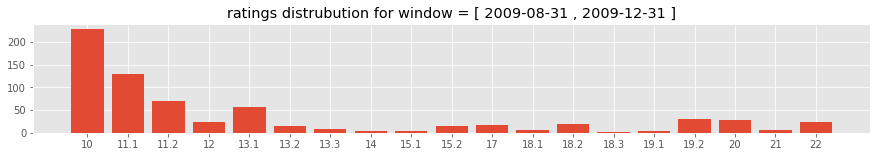

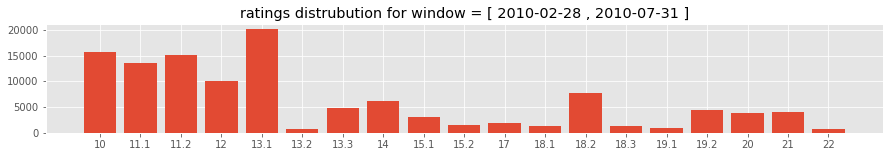

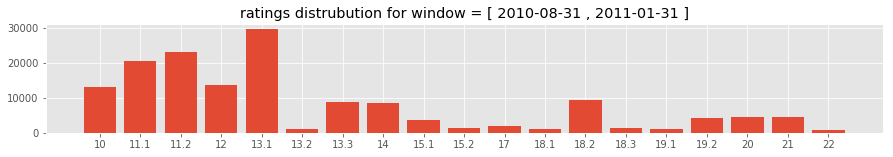

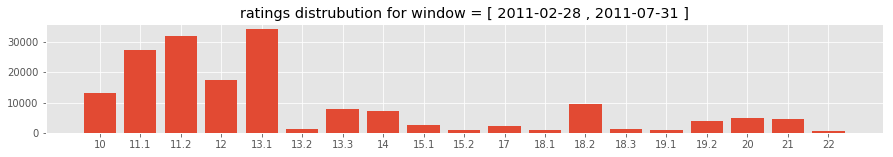

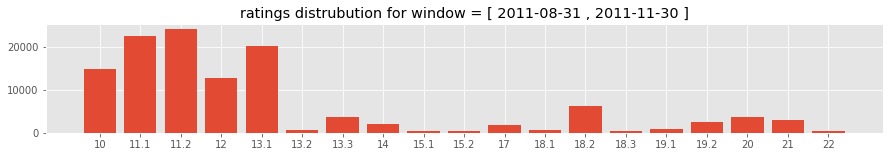

In [488]:
ratings = np.sort(data['rating'].unique())
x_pos = np.arange(len(ratings))

window = 6
i_lower = 0
i_upper = 4
while i_lower < len(reporting_dates):
    lower = reporting_dates[i_lower]
    upper = reporting_dates[i_upper]
    mask = (data['reporting_date']>=lower) & (data['reporting_date']<=upper)
    data_short = data[mask]

    rating_distr = data_short[['rating', 'customer_id']].groupby('rating').count().reset_index()

    lower_str = pd.to_datetime(str(lower)).strftime('%Y-%m-%d')
    upper_str = pd.to_datetime(str(upper)).strftime('%Y-%m-%d')
    
    plt.figure(figsize=(15,2))
    plt.title('ratings distrubution for window = [ '+lower_str+' , '+upper_str+ ' ]')
    plt.bar(x_pos, rating_distr['customer_id'])
    plt.xticks(x_pos, ratings)
    plt.show()
    
    i_lower += window
    i_upper = i_lower+5
    if i_upper >= len(reporting_dates):
        i_upper = len(reporting_dates)-1

***
#### Average DR change over time

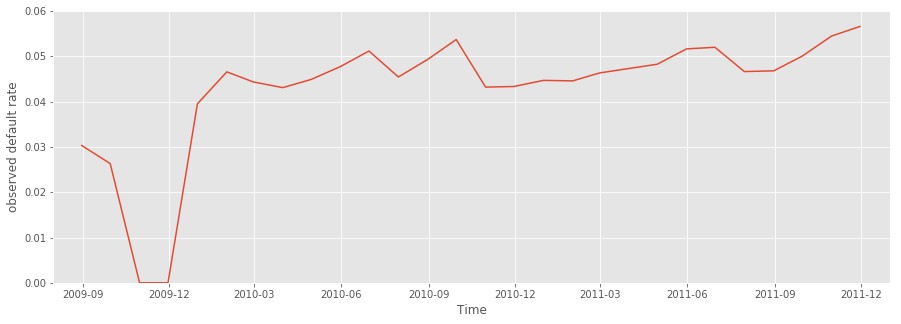

In [454]:
DR = data[['reporting_date', 'intodefault']].groupby('reporting_date').mean()

plt.figure(figsize=(15,5))
plt.plot(DR.index, DR.intodefault)
plt.xlabel('Time')
plt.ylabel('observed default rate')
plt.ylim(0,0.06)
plt.xlim('2009-08-01','2012-01-01')
plt.show()

Seems more or less stable, however it is better to check how DR changes for different ratings.

C:\Users\Konstantin.Singurov\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


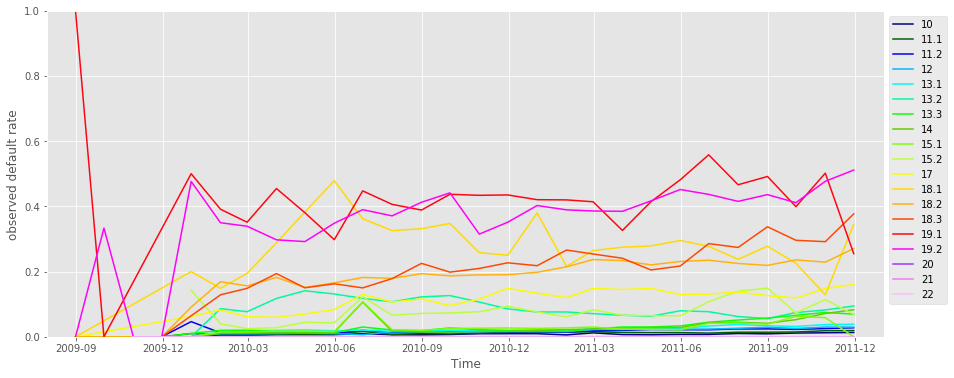

In [504]:
ratings = np.sort(data['rating'].unique())

DR_all = tuple()

i = 0
while i < len(ratings):
    mask = (data['rating'] == ratings[i])
    DR = data[mask][['reporting_date', 'intodefault']].groupby('reporting_date').mean()
    DR_all = DR_all + (DR,)    
    i += 1

plt.figure(figsize=(15,6))
num_plots = len(DR_all)
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.95, num_plots)])

i=0
while i < len(ratings):
    plt.plot(DR_all[i].index, DR_all[i].intodefault)
    i += 1
plt.legend(ratings, loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('Time')
plt.ylabel('observed default rate')
plt.xlim('2009-08-01','2012-01-01')
plt.ylim(0,1)

plt.show()

We definitely see that there is an issue with calibration:
- Ratings' DRs overlap with neighboring ratings' DRs
- Average DR for ratings changes over time

***
#### Proxy score change over time

Let's convert DRs to proxy scores for different ratings and see how they change. 

C:\Users\Konstantin.Singurov\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Konstantin.Singurov\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


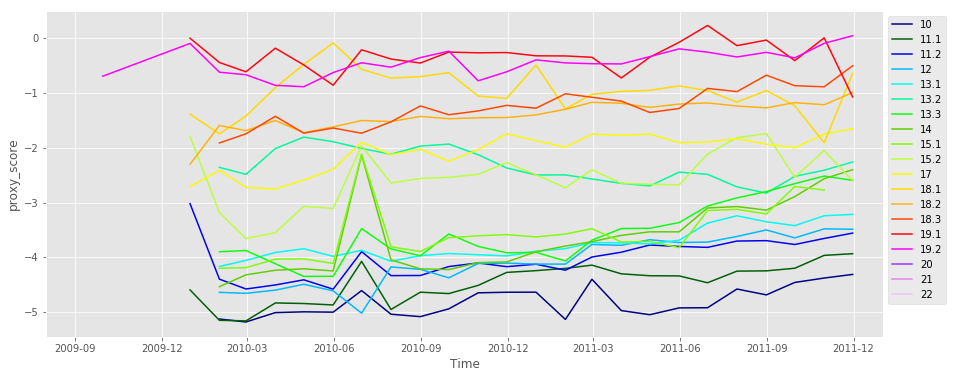

In [491]:
score_all = tuple()
i=0
while i < len(ratings): 
    p = DR_all[i]
    score = np.log(p/(1-p))
    score = score.replace([np.inf, -np.inf], np.nan).dropna()
    score_all = score_all + (score,)
    i += 1

plt.figure(figsize=(15,6))
num_plots = len(score_all)
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.95, num_plots)])

i=0
while i < len(ratings):
    plt.plot(score_all[i].index, score_all[i].intodefault)
    i += 1
plt.legend(ratings, loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('Time')
plt.ylabel('proxy_score')
plt.xlim('2009-08-01','2012-01-01')
plt.show()

***
#### DR and proxy score change over time with aggregated sub-ratings

C:\Users\Konstantin.Singurov\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


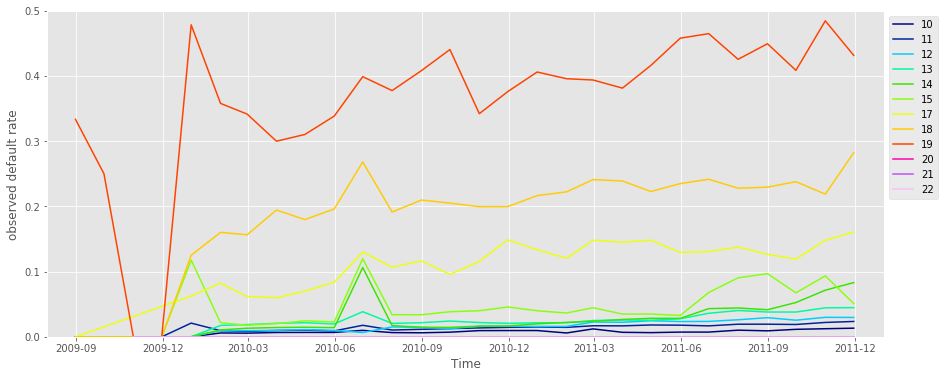

In [527]:
ratings = np.sort(data['rating_num'].unique())

DR_all = tuple()

i = 0
while i < len(ratings):
    mask = (data['rating_num'] == ratings[i])
    DR = data[mask][['reporting_date', 'intodefault']].groupby('reporting_date').mean()
    DR_all = DR_all + (DR,)    
    i += 1

plt.figure(figsize=(15,6))
num_plots = len(DR_all)
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.95, num_plots)])

i=0
while i < len(ratings):
    plt.plot(DR_all[i].index, DR_all[i].intodefault)
    i += 1
plt.legend(ratings, loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('Time')
plt.ylabel('observed default rate')
plt.xlim('2009-08-01','2012-01-01')
plt.ylim(0,0.5)

plt.show()

C:\Users\Konstantin.Singurov\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Konstantin.Singurov\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


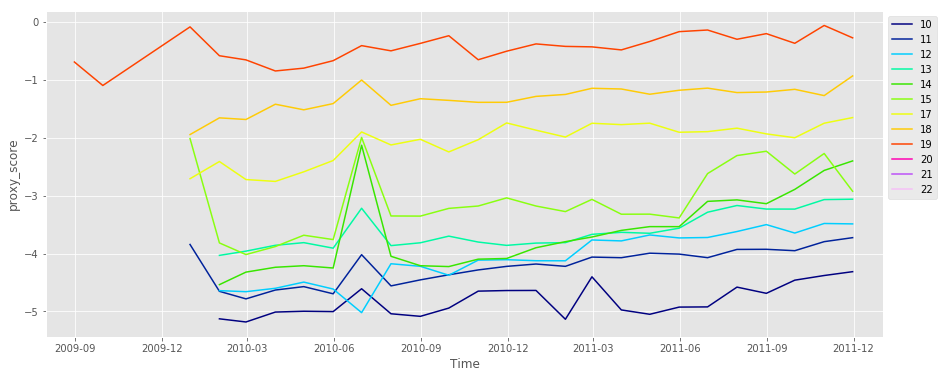

In [528]:
score_all = tuple()
i=0
while i < len(ratings): 
    p = DR_all[i]
    score = np.log(p/(1-p))
    score = score.replace([np.inf, -np.inf], np.nan).dropna()
    score_all = score_all + (score,)
    i += 1

plt.figure(figsize=(15,6))
num_plots = len(score_all)
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.95, num_plots)])

i=0
while i < len(ratings):
    plt.plot(score_all[i].index, score_all[i].intodefault)
    i += 1
plt.legend(ratings, loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('Time')
plt.ylabel('proxy_score')
plt.xlim('2009-08-01','2012-01-01')
plt.show()

After elimination of sub-ratings we see that the situation become a bit better. There are almost no overlaps. However avegage DRs for ratings are still unstable over time. Moreover there is really strange hike in proxy score and DR in July 2018.

***
### Conclusions
- __Discrininatory power of the model rating:__
    - The model has modest dicriminatory power with Gini on the whole sample.
    - However there is obvious deterioration of dicriminatory power over time with Gini decreasing from 65,9% to 50,6%.


- __Calibration accuracy:__
    - The most important obsevation is instability of default rates for different ratings over time.
    - There is non monotonous relation between default rates and ratings.
    - For several bad ratings there is no defaults at all.
    
The results of performed analysis indicate that model lacks calibration accuracy.

***
### Appendix

Here is another method to calculate Gini. Areas under CAP curves for perfect and actual models are calculated as integrals using scipy library. It could be seen that the result is identical.

In [648]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

p = data['intodefault'].sum()/data['intodefault'].count()

distr_data = data[['intodefault','rating']].groupby('rating').agg(['sum', 'count'])
distr_data.columns = distr_data.columns.droplevel()
distr_data.reset_index(inplace=True)
distr_data.loc[len(distr_data)] = 0
distr_data.sort_index(ascending=False, inplace=True)
distr_data.reset_index(inplace=True, drop=True)

distr_data[['sum', 'count']] = distr_data[['sum', 'count']]/distr_data[['sum', 'count']].sum()
distr_data[['sum', 'count']] = distr_data[['sum', 'count']].cumsum()

f = distr_data['sum']
x = distr_data['count']

f_actual = interp1d(x, f)
f_perfect = interp1d(pd.Series([0,p,1]), pd.Series([0,1,1]))
f_perfect = interp1d([0,p,1], [0,1,1])

S_actual = quad(f_actual, 0, 1, points=x)[0] - 0.5
S_perfect = quad(f_perfect, 0, 1, points=x)[0] - 0.5

gini = S_actual/S_perfect
print(round(100*gini, 1),'%')

52.5 %
